#                                      SUICIDES PROYECTO 

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-2.3.3-bin-hadoop2.7'

In [2]:
#solo correrla una vez / es el contexto
from pyspark import SparkContext, SparkConf
sc=SparkContext(master="local[3]")
print (sc)

<SparkContext master=local[3] appName=pyspark-shell>


In [3]:
#me creo la aplicación
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("nombre_de_la_aplicacion").getOrCreate()

________________________________________________________________________________________________________________________

### PREPRAMOS EL DATASET

In [4]:
import pyspark.sql.types as typ

labels = [
    ('country', typ.StringType()),
    ('year', typ.IntegerType()),
    ('sex', typ.StringType()),
    ('age', typ.StringType()),
    ('suicide_no', typ.IntegerType()),
    ('population', typ.IntegerType()),
    ('suicides/100k pop', typ.DoubleType()),
    ('country-year', typ.StringType()),
    ('HDI for year', typ.DoubleType()),
    (' gdp_for_year ($) ', typ.StringType()),
    ('gdp_per_capita ($)', typ.IntegerType()),
    ('generation', typ.StringType())
]

mi_schema = typ.StructType([typ.StructField(e[0], e[1], False) for e in labels])

In [5]:
suicides =spark.read.csv('master.csv',header='true', inferSchema='false',schema = mi_schema,  sep=',')

In [6]:
suicides = suicides.withColumnRenamed('suicides/100k pop','Num_Suicides_100k')
suicides = suicides.withColumnRenamed('HDI for year','IDH_Y')
suicides = suicides.withColumnRenamed(' gdp_for_year ($) ','PIB_Y')
suicides = suicides.withColumnRenamed('gdp_per_capita ($)','PIB_PerCapita')

##### CATEGORIZAMOS LAS VARIABLES 'SEX' Y 'YEAR'

In [7]:
edades = []
for i in range(suicides.select('age').distinct().count()):
    edades.append(suicides.select('age').distinct().collect()[i][0])
edades

['55-74 years',
 '25-34 years',
 '5-14 years',
 '75+ years',
 '15-24 years',
 '35-54 years']

In [8]:
import pyspark.sql.types as typ
from pyspark.sql.functions import col, expr, when

#suicides = suicides.withColumn('sexBin', when((col("sex") == "male").otherwise(0)))
new_column = when(col("sex") == 'male' , 0).when(col("sex")=='female', 1)
suicides = suicides.withColumn("sex" , new_column)

new_column_1 = when(col("age") == edades[2] , 0).when(col("age") == edades[4] , 1)\
                .when(col("age") == edades[1] , 2).when(col("age") == edades[5] , 3)\
                .when(col("age") == edades[0] , 4).when(col("age") == edades[3] , 5)
suicides = suicides.withColumn("age" , new_column_1)

suicides.select('sex','age').show(5)

+---+---+
|sex|age|
+---+---+
|  0|  1|
|  0|  3|
|  1|  1|
|  0|  5|
|  0|  2|
+---+---+
only showing top 5 rows



_____________________________________________________________________________________________________________________

### PROBANDO LAS FUNCIONES DE PYSPARK (count , filter , distinct , collect ,etc)

In [9]:
pandaDf = suicides.toPandas()

In [10]:
pandaDf['country'].count()

27820

In [11]:
pandaDf.isnull().sum()

country                  0
year                     0
sex                      0
age                      0
suicide_no               0
population               0
Num_Suicides_100k        0
country-year             0
IDH_Y                19456
PIB_Y                    0
PIB_PerCapita            0
generation               0
dtype: int64

In [12]:
19456/len(pandaDf)

0.699352983465133

In [13]:
tabla_corr = pandaDf.corr()
tabla_corr.style.background_gradient(cmap='coolwarm')

,year,sex,age,suicide_no,population,Num_Suicides_100k,IDH_Y,PIB_PerCapita
year,1,0,0.00293288,-0.00454596,0.00885017,-0.0390368,0.366786,0.339134
sex,0,1,6.45364e-19,-0.144629,0.0112421,-0.391496,1.42177e-19,-1.33626e-18
age,0.00293288,6.45364e-19,1,0.0798924,-0.0607161,0.362587,-5.82753e-19,0.000784917
suicide_no,-0.00454596,-0.144629,0.0798924,1,0.616162,0.306604,0.151399,0.0613297
population,0.00885017,0.0112421,-0.0607161,0.616162,1,0.00828497,0.102943,0.0815099
Num_Suicides_100k,-0.0390368,-0.391496,0.362587,0.306604,0.00828497,1,0.0742791,0.00178513
IDH_Y,0.366786,1.42177e-19,-5.82753e-19,0.151399,0.102943,0.0742791,1,0.771228
PIB_PerCapita,0.339134,-1.33626e-18,0.000784917,0.0613297,0.0815099,0.00178513,0.771228,1


In [14]:
Num_Country1 = suicides.groupBy('country').count()
Num_Country2 = suicides.select('country').distinct().count()
Num_Country3 = Num_Country1.select('count').count()
Num_Country2

101

In [15]:
SpainSuicides = suicides.select("country","year","suicide_no").filter("country = 'Spain'")
SpainSuicides.show(5)

+-------+----+----------+
|country|year|suicide_no|
+-------+----+----------+
|  Spain|1985|       305|
|  Spain|1985|       624|
|  Spain|1985|       131|
|  Spain|1985|       497|
|  Spain|1985|       219|
+-------+----+----------+
only showing top 5 rows



In [16]:
corr = suicides.corr( 'suicide_no','Num_Suicides_100k' )
corr

0.30660445126778024

In [17]:
maxSuicide = max(suicides.select('suicide_no').collect())[0]
PaisxSuicides = suicides.select('country' ,'year' ,'sex' , 'age' , 'Num_Suicides_100k', 'suicide_no','population')\
                        .filter("suicide_no = 22338").show()

+------------------+----+---+---+-----------------+----------+----------+
|           country|year|sex|age|Num_Suicides_100k|suicide_no|population|
+------------------+----+---+---+-----------------+----------+----------+
|Russian Federation|1994|  0|  3|            117.3|     22338|  19044200|
+------------------+----+---+---+-----------------+----------+----------+



In [18]:
max(suicides.select('Num_Suicides_100k').collect())[0]

224.97

In [19]:
max(suicides.select('suicide_no').collect())

Row(suicide_no=22338)

In [20]:
suicides.select('year').distinct().count()

32

______________________________________________________________________________________________________________________________

### PROBLEMA

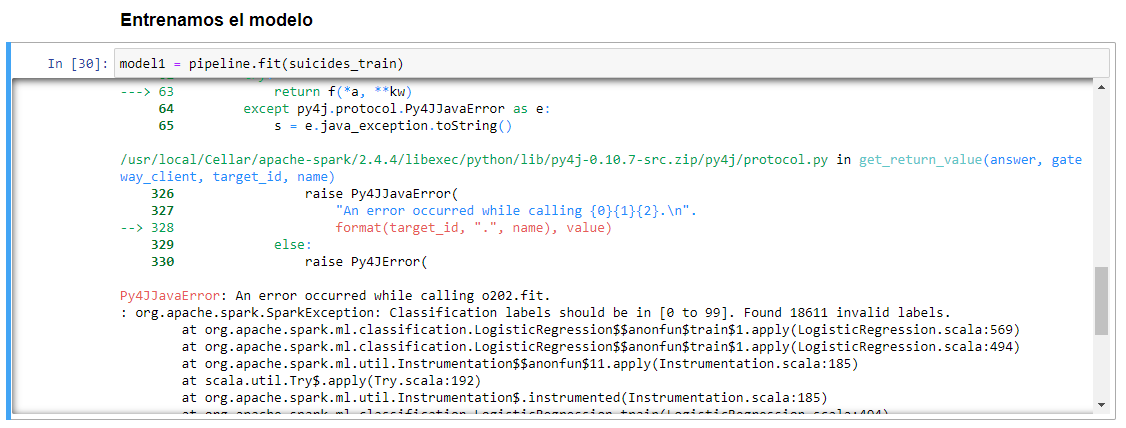

In [21]:
from IPython.display import Image

Image("imagen.png")

____________________________________________________________________________________________________________

### CREAMOS LOS TRANSFORMERS

In [22]:
#suicides = suicides.withColumn('suicides_num', suicides['suicide_no'].cast(typ.DoubleType()))
#suicides = suicides.withColumn('population', suicides['population'].cast(typ.DoubleType()))
#suicides = suicides.withColumn('PIB_PerCapita', suicides['PIB_PerCapita'].cast(typ.DoubleType()))
#suicides = suicides.withColumn('sex', suicides['sex'].cast(typ.DoubleType()))
suicides = suicides.withColumn('age', suicides['age'].cast(typ.DoubleType()))

ENCODER

In [23]:
import pyspark.ml.feature as ft

encoder = ft.OneHotEncoder(inputCol='age',outputCol='age_vec')

VECTOR ASSEMBLER

In [24]:
import pyspark.ml.feature as ft

labels = ['year','population','Num_Suicides_100k', 'PIB_PerCapita', 'suicide_no']
featuresCreator = ft.VectorAssembler(inputCols = labels + [encoder.getOutputCol() ] ,outputCol = 'features')

### CREAMOS EL LOGISTIC REGRESION

In [25]:
import pyspark.ml.classification as cl

logistic = cl.LogisticRegression(
    maxIter=10, 
    regParam=0.01,
    labelCol='sex'
    )

### CREAMOS EL PIPELINE Y ENTRENAMOS EL MODELO

In [26]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[encoder, featuresCreator, logistic])

In [27]:
suicides_train, suicides_test = suicides.randomSplit([0.8, 0.2], seed=666)

In [28]:
model = pipeline.fit(suicides_train)

In [29]:
test_model = model.transform(suicides_test)

In [30]:
test_model.take(1)

[Row(country='Albania', year=1987, sex=0, age=5.0, suicide_no=1, population=21800, Num_Suicides_100k=4.59, country-year='Albania1987', IDH_Y=None, PIB_Y='2,156,624,900', PIB_PerCapita=796, generation='G.I. Generation', age_vec=SparseVector(5, {}), features=SparseVector(10, {0: 1987.0, 1: 21800.0, 2: 4.59, 3: 796.0, 4: 1.0}), rawPrediction=DenseVector([-0.524, 0.524]), probability=DenseVector([0.3719, 0.6281]), prediction=1.0)]

EVALUACIÓN DEL MODELO LOGISTIC REGRESSION

In [31]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='sex')

print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.7925511472916509
0.7505485461873778


ACCURACY DEL MODELO LOGISTIC REGRESSION

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test_model)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.727549


### HACEMOS EL HYPER-TUNNING Y CREAMOS EL GRID DEL LOGISTIC REGRESSION

In [33]:
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev

In [34]:
logistic = cl.LogisticRegression(labelCol='sex')

grid = tune.ParamGridBuilder().addGrid(logistic.maxIter, [2, 10, 50]).addGrid(logistic.regParam, [0.01, 0.05, 0.3]).build()

In [35]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='sex')

In [36]:
cv = tune.CrossValidator(estimator=logistic, estimatorParamMaps=grid, evaluator=evaluator)

In [37]:
pipeline = Pipeline(stages=[encoder, featuresCreator])

In [38]:
data_transformer = pipeline.fit(suicides_train)

In [39]:
cvModel = cv.fit(data_transformer.transform(suicides_train))

In [40]:
data_train = data_transformer.transform(suicides_test)

EVALUACION DEL HYPERTUNNING DEL MODELO LOGISTIC REGRESSION

In [41]:
results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.7937150404888903
0.7444078048665009


ACCURACY DEL HYPERTUNNING DEL MODELO LOGISTIC REGRESSION

In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='sex', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(results)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.7213


________________________________________________________________________________________________________________________

### CREAMOS EL RANDOMFOREST

In [45]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="sex", outputCol="sex_indexer").fit(suicides)

### CREAMOS EL PIPELINE Y ENTRENAMOS EL MODELO

In [46]:
suicides_train, suicides_test = suicides.randomSplit([0.8 , 0.2], seed=666)

In [47]:
from pyspark.ml import Pipeline

classifier = cl.RandomForestClassifier(
    numTrees=5, 
    maxDepth=5, 
    labelCol='sex_indexer')

In [48]:
pipeline = Pipeline(stages=[encoder, indexer, featuresCreator, classifier])

In [49]:
model1 = pipeline.fit(suicides_train)

In [50]:
test = model1.transform(suicides_test)

In [51]:
test.take(1)

[Row(country='Albania', year=1987, sex=0, age=5.0, suicide_no=1, population=21800, Num_Suicides_100k=4.59, country-year='Albania1987', IDH_Y=None, PIB_Y='2,156,624,900', PIB_PerCapita=796, generation='G.I. Generation', age_vec=SparseVector(5, {}), sex_indexer=0.0, features=SparseVector(10, {0: 1987.0, 1: 21800.0, 2: 4.59, 3: 796.0, 4: 1.0}), rawPrediction=DenseVector([1.8153, 3.1847]), probability=DenseVector([0.3631, 0.6369]), prediction=1.0)]

EVALUACION DEL MODELO RANDOMFOREST

In [52]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='sex_indexer')

print(evaluator.evaluate(test,{evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test,{evaluator.metricName: 'areaUnderPR'}))

0.8147883545396178
0.79508295004224


ACCURACY DEL MODELO RANDOMFOREST

In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='sex_indexer', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.728798


### HACEMOS EL HYPER-TUNNING Y CREAMOS EL GRID DEL RANDOM FOREST

In [54]:
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev

In [55]:
classifier = cl.RandomForestClassifier(numTrees=5, maxDepth=5, labelCol='sex_indexer')

grid = tune.ParamGridBuilder().addGrid(classifier.numTrees, [2,4,6,8]).addGrid(classifier.maxDepth, [3,5,8,12]).build()

In [56]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='sex_indexer')

In [57]:
cv = tune.CrossValidator(estimator=classifier, estimatorParamMaps=grid, evaluator=evaluator)

In [58]:
pipeline = Pipeline(stages=[encoder, indexer, featuresCreator])

In [59]:
data_transformer = pipeline.fit(suicides_train)

In [60]:
cvModel1 = cv.fit(data_transformer.transform(suicides_train))

EVALUACION DEL HYPERTUNNING DEL MODELO RANDOMFOREST

In [61]:
data_train = data_transformer.transform(suicides_test)
results = cvModel1.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.8776069652020436
0.8756600460127482


ACCURACY DEL HYPERTUNNING DEL MODELO RANDOMFOREST

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex_indexer', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(results)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.774683


CUAL ES EL MEJOR ESTIMADOR OBTENIDO MEDIANTE HYPERTUNNING:

In [63]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'maxIter': 50}, {'regParam': 0.01}], 0.7889401587200806)

_______________________________________________________________________________________________________________________________

### MEJORAS DEL MODELO

Vamos a implementar más transformes en nuestro modelo para que clasifique de una manera más óptima

#### VECTORIZER

In [64]:
vectorizer = ft.VectorAssembler(inputCols=['suicide_no' , 'PIB_PerCapita'], outputCol= 'continuous_vec')

#### NORMALIZER

In [65]:
normalizer = ft.StandardScaler(
    inputCol=vectorizer.getOutputCol(), 
    outputCol='normalized', 
    withMean=True,
    withStd=True
)

#### PCA

In [66]:
from pyspark.ml.feature import PCA

pca = PCA(k=6, inputCol = 'features' , outputCol = 'pcaFeature')

#### NUEVO VECTOR ASSEMBLER

In [67]:
import pyspark.ml.feature as ft

labels = ['year','population','Num_Suicides_100k']
featuresCreator = ft.VectorAssembler(inputCols = labels + [encoder.getOutputCol() ] ,outputCol = 'features')

_____________________________________________________________________________________________________________________________

### IMPLEMENTAMOS LAS MEJORAS EN EL MODELO LOGISTIC REGRESSION

In [68]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[encoder, vectorizer , normalizer, featuresCreator,pca, logistic])

In [69]:
suicides_train, suicides_test = suicides.randomSplit([0.8, 0.2], seed=666) 

In [70]:
model = pipeline.fit(suicides_train)

In [71]:
test_model = model.transform(suicides_test)

In [72]:
test_model.take(1)

[Row(country='Albania', year=1987, sex=0, age=5.0, suicide_no=1, population=21800, Num_Suicides_100k=4.59, country-year='Albania1987', IDH_Y=None, PIB_Y='2,156,624,900', PIB_PerCapita=796, generation='G.I. Generation', age_vec=SparseVector(5, {}), continuous_vec=DenseVector([1.0, 796.0]), normalized=DenseVector([-0.2642, -0.8496]), features=SparseVector(8, {0: 1987.0, 1: 21800.0, 2: 4.59}), pcaFeature=DenseVector([-21800.0, -40.3562, 1986.5945, 0.4259, -0.024, 0.1916]), rawPrediction=DenseVector([-1.3528, 1.3528]), probability=DenseVector([0.2054, 0.7946]), prediction=1.0)]

EVALUACIÓN DEL MODELO LOGISTIC REGRESSION CON MEJORAS

In [73]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='sex')

print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.7918149159900647
0.7269264518065534


ACCURACY DEL MODELO LOGISTIC REGRESSION CON MEJORAS

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test_model)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.729691


### IMPLEMENTAMOS LAS MEJORAS EN EL HYPERTUNNING DEL LOGISTIC REGRESSION

In [75]:
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev

In [76]:
logistic = cl.LogisticRegression(labelCol='sex')

In [77]:
grid = tune.ParamGridBuilder().addGrid(logistic.maxIter, [2, 10, 50]).addGrid(logistic.regParam, [0.01, 0.05, 0.3]).build()

In [78]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='sex')

In [79]:
cv = tune.CrossValidator(estimator=logistic, estimatorParamMaps=grid, evaluator=evaluator)

In [80]:
pipeline = Pipeline(stages=[encoder, featuresCreator])

In [81]:
data_transformer = pipeline.fit(suicides_train)

In [82]:
cvModel = cv.fit(data_transformer.transform(suicides_train))

In [83]:
data_train = data_transformer.transform(suicides_test)

EVALUACIÓN DEL HYPERTUNNING DEL MODELO LOGISTIC REGRESSION CON MEJORAS

In [84]:
results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.7918988162665559
0.7263445020194723


ACCURACY DEL HYPERTUNNING DEL MODELO LOGISTIC REGRESSION CON MEJORAS

In [85]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test_model)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.729691


### IMPLEMENTAMOS LAS MEJORAS EN EL MODELO RANDOM FOREST

In [86]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[encoder, indexer, vectorizer, normalizer, featuresCreator, pca, logistic])

In [87]:
suicides_train, suicides_test = suicides.randomSplit([0.8, 0.2], seed=666) 

In [88]:
model = pipeline.fit(suicides_train)

In [89]:
test_model = model.transform(suicides_test)

In [90]:
test_model.take(1)

[Row(country='Albania', year=1987, sex=0, age=5.0, suicide_no=1, population=21800, Num_Suicides_100k=4.59, country-year='Albania1987', IDH_Y=None, PIB_Y='2,156,624,900', PIB_PerCapita=796, generation='G.I. Generation', age_vec=SparseVector(5, {}), sex_indexer=0.0, continuous_vec=DenseVector([1.0, 796.0]), normalized=DenseVector([-0.2642, -0.8496]), features=SparseVector(8, {0: 1987.0, 1: 21800.0, 2: 4.59}), pcaFeature=DenseVector([-21800.0, -40.3562, 1986.5945, 0.4259, -0.024, 0.1916]), rawPrediction=DenseVector([-1.3528, 1.3528]), probability=DenseVector([0.2054, 0.7946]), prediction=1.0)]

EVALUACION DEL MODELO RANDOMFOREST CON MEJORAS

In [91]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='sex')

print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

0.7918149159900647
0.7269264518065534


ACCURACY DEL MODELO RANDOMFOREST CON MEJORAS

In [92]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(test_model)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.729691


### IMPLEMENTAMOS LAS MEJORAS EN EL HYPERTUNNING DEL RANDOM FOREST

In [93]:
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev

In [94]:
classifier = cl.RandomForestClassifier(numTrees=5, maxDepth=5, labelCol='sex_indexer')

grid = tune.ParamGridBuilder().addGrid(classifier.numTrees, [2,4,6,8]).addGrid(classifier.maxDepth, [3,5,8,12]).build()

In [95]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='sex_indexer')

In [96]:
cv = tune.CrossValidator(estimator=classifier, estimatorParamMaps=grid, evaluator=evaluator)

In [97]:
pipeline = Pipeline(stages=[encoder, indexer ,vectorizer , normalizer, featuresCreator, pca])
data_transformer = pipeline.fit(suicides_train)

In [98]:
cvModel = cv.fit(data_transformer.transform(suicides_train))

EVALUACION DEL HYPERTUNNING DEL MODELO RANDOMFOREST CON MEJORAS

In [99]:
data_train = data_transformer.transform(suicides_test)
results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

0.8364883067496104
0.822338855820921


ACCURACY DEL HYPERTUNNING DEL MODELO RANDOMFOREST CON MEJORAS

In [100]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='sex_indexer', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(results)
print('Accuracy = %g'  % accuracy)

Accuracy = 0.750937


In [101]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'numTrees': 8}, {'maxDepth': 12}], 0.8340217561417034)

___________________________________________________________________________________________________________________

### CONCLUSIÓN

______________________________________________________________________________________________________________________________

### FIN